Package Installation

In [1]:
#!pip install src
#!pip install lifelines

Load packages to use

In [70]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

import seaborn as sns
import statsmodels.api as sm # give you lots of stat

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import lifelines
from datetime import date
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from lifelines import KaplanMeierFitter
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

Load raw Dataset

In [8]:
df = pd.read_csv('../Data/data_churn_model.csv')
df.head()

,ID_Country,Country,Employee_Pay_ST,Track,Level_Cat,Level,Effective_Start_DT,Effective_Ending_DT,Termination_Reason,Birth_DT,...,Media_hora_curso,Estado,Total_number_received_Feedback,Performance_feedback_AVG,Performance_Level_CD,Performance_Level,Potential_Level_CD,Potential_Level,Track_Code,TotalNumberOfficeEmployees
0,2,MX,Active,SYINCO,5,Sr. Consultant,12/01/2001,1/29/2021,Still Active,16/09/1971,...,16.0,Activo,0.0,91.789248,2,Medium,0,No Employee info,8,1441
1,2,MX,Active,DEVELO,5,Sr. Consultant,8/23/2018,1/29/2021,Still Active,10/10/1966,...,10.0,Activo,19.0,91.630000,2,Medium,0,No Employee info,3,1441
2,2,MX,Active,CONSUL,6,Manager / Master,08/01/2009,1/29/2021,Still Active,03/09/1972,...,2.0,Activo,0.0,91.789248,0,High,0,No Employee info,2,1441
3,2,MX,Active,MNGSER,3,Experienced Consultant,11/16/2017,1/29/2021,Still Active,22/11/1970,...,14.0,Activo,0.0,91.789248,2,Medium,0,No Employee info,4,1441
4,2,MX,Active,PROJCT,6,Manager / Master,10/01/1995,1/29/2021,Still Active,25/06/1974,...,4.0,Activo,2.0,50.000000,2,Medium,1,RISING TALENT,5,1441


### Discard non-meaningful features for the analysis

##### 1)  Gender
##### 2)  Effective Start Date
##### 3)  Effectivo Ending Date
##### 4)  Marital_ST
##### 5)  DateOfBirth
##### 6)  Proportional_Days
##### 7)  Days_Taken
##### 8)  2019
##### 9)  2020

In [9]:
DropColumns = ['Gender','Effective_Start_DT','Effective_Ending_DT','Marital_ST','Birth_DT','Proportional_Days','Days_Taken','2019','2020']
df.drop(DropColumns, axis=1, inplace=True)

In [10]:
df.head()

,ID_Country,Country,Employee_Pay_ST,Track,Level_Cat,Level,Termination_Reason,Edad,Marital_CD,SBR_AMT,...,Media_hora_curso,Estado,Total_number_received_Feedback,Performance_feedback_AVG,Performance_Level_CD,Performance_Level,Potential_Level_CD,Potential_Level,Track_Code,TotalNumberOfficeEmployees
0,2,MX,Active,SYINCO,5,Sr. Consultant,Still Active,49,2,106.80,...,16.0,Activo,0.0,91.789248,2,Medium,0,No Employee info,8,1441
1,2,MX,Active,DEVELO,5,Sr. Consultant,Still Active,54,2,79.21,...,10.0,Activo,19.0,91.630000,2,Medium,0,No Employee info,3,1441
2,2,MX,Active,CONSUL,6,Manager / Master,Still Active,48,2,161.50,...,2.0,Activo,0.0,91.789248,0,High,0,No Employee info,2,1441
3,2,MX,Active,MNGSER,3,Experienced Consultant,Still Active,49,2,42.00,...,14.0,Activo,0.0,91.789248,2,Medium,0,No Employee info,4,1441
4,2,MX,Active,PROJCT,6,Manager / Master,Still Active,46,1,172.00,...,4.0,Activo,2.0,50.000000,2,Medium,1,RISING TALENT,5,1441


In [11]:
#df['Estado'] = df['Estado'].replace(['Inactivo','Activo'],[int(1),int(0)])
df.loc[df['Termination_Reason'] == 'Still Active', 'Churn'] = 0
df.loc[df['Termination_Reason'] != 'Still Active', 'Churn'] = 1


### Filter all the records with Months Worked <= 72

In [12]:
df['Level'].count() # Conteo antes de limitar a 72 meses de antiguedad

3429

In [13]:
df = df[df['Months_Worked'] <= 72]

In [14]:
df['Months_Worked'].unique()

array([29, 38, 32, 27, 26, 28,  3, 35, 42, 40, 65, 49, 12, 55, 47, 46, 71,
       34, 43, 21, 17, 51, 23, 60,  5, 64, 30, 48, 19, 67, 18, 37, 61, 10,
       33, 39, 36, 63, 53, 20, 52, 72, 57, 69, 68, 41, 62, 16, 59, 58, 56,
       54,  9, 11, 50, 45, 44, 15, 14, 25, 31, 24, 22,  4, 13,  8,  7,  6,
        2,  1,  0, 66, 70], dtype=int64)

### Classify the Level with values M=Managers and T=Technicals in new column TypeEmployee

In [15]:
df['Level'].count() # Count before the analysis by type of employee MANAGER or TECHNICAL


2760

In [16]:
TypeManager = ['Associate Director','Manager / Master','Sr. Manager / SME']
TypeTechnical = ['Analyst','Consultant','Experienced Consultant','Project / Technical Lead','Sr. Consultant']
df = df[df['Level'].isin(TypeTechnical)] # Change the variable to obtain a different analysis
df['Level'].count()


2627

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2627 entries, 1 to 3428
Data columns (total 58 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID_Country                      2627 non-null   int64  
 1   Country                         2627 non-null   object 
 2   Employee_Pay_ST                 2627 non-null   object 
 3   Track                           2627 non-null   object 
 4   Level_Cat                       2627 non-null   int64  
 5   Level                           2627 non-null   object 
 6   Termination_Reason              2627 non-null   object 
 7   Edad                            2627 non-null   int64  
 8   Marital_CD                      2627 non-null   int64  
 9   SBR_AMT                         2627 non-null   float64
 10  SCR_AMT                         2627 non-null   float64
 11  Region                          2562 non-null   float64
 12  Office                          26

In [18]:
df['Churn'].unique()

array([0., 1.])

In [19]:
item_counts = df["Churn"].value_counts()
print(item_counts)

0.0    1740
1.0     887
Name: Churn, dtype: int64


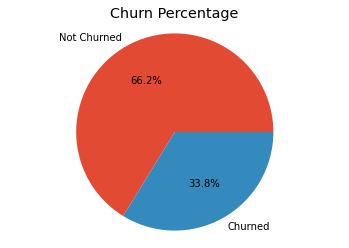

In [20]:
churn_labels = 'Not Churned', 'Churned'
plt.pie(item_counts, labels = churn_labels, autopct='%1.1f%%')
plt.title('Churn Percentage')
plt.axis('equal')
plt.show()

In [21]:
print(df.groupby("Prime_Skills")["Churn"].count())

Prime_Skills
.NET DEVELOPER                                                        364
ANGULAR                                                                48
BUSINESS CONSULTANT (PMO + PROCESSES + CHANGE MGT + BUSINESS CASE)     52
FINANCE                                                                 1
FUNCTIONAL ANALYST                                                    134
INFORMATICA POWERCENTER                                                24
IT                                                                     61
JAVA                                                                  335
JIRA (ZEPHYR)                                                          70
LINES OF SERVICES MANAGER                                               2
MICROFOCUS QC/ALM                                                     125
MICROSOFT DYNAMICS 365                                                 31
ORACLE                                                                 47
Other                    

In [22]:
print(df.groupby("Prime_Skills")["Churn"].sum())

Prime_Skills
.NET DEVELOPER                                                        138.0
ANGULAR                                                                17.0
BUSINESS CONSULTANT (PMO + PROCESSES + CHANGE MGT + BUSINESS CASE)     33.0
FINANCE                                                                 0.0
FUNCTIONAL ANALYST                                                     46.0
INFORMATICA POWERCENTER                                                10.0
IT                                                                     10.0
JAVA                                                                  125.0
JIRA (ZEPHYR)                                                          15.0
LINES OF SERVICES MANAGER                                               0.0
MICROFOCUS QC/ALM                                                      66.0
MICROSOFT DYNAMICS 365                                                  8.0
ORACLE                                                                 20.0

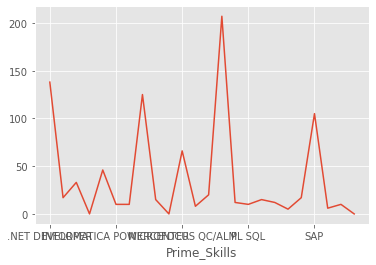

In [23]:
df_by_pskill = df.groupby("Prime_Skills")["Churn"].sum()
df_by_pskill.plot()

## ENCODE de la columna PRIME SKILLS

##### 1=NET DEVELOPER {.NET DEVELOPER[0] + ANGULAR[1] + PHP[14]}
##### 2=JAVA {JAVA[7]}
##### 3=APP {MICROFOCUS QC/ALM[10] + MICROSOFT DYNAMICS 365[11]}
##### 4=OTHER TECHNICAL SKILLS {INFORMATICA POWERCENTER[5]+IT[6]+ORACLE[12]+PL SQL[15]+SALESFORCE[19]+TELCO[21]}
##### 5=SAP {SAP[5]}
##### 6=OTHER ADMINISTRATIVE SKILLS {BUSINESS CONSULTANT (PMO + PROCESSES + CHANGE MGT + BUSINESS CASE)[2]+FINANCE[3]+FUNCTIONAL ANALYST[4]+JIRA (ZEPHYR)[8]+LINES OF SERVICES MANAGER[9]+PMO[16]+PROJECT LEADER[17]+PROJECT MANAGER[18]+USER EXPERIENCE DESIGNER (UX)[22]+VERTICAL MANAGER[23]}
##### 7=Other[13]

In [24]:
def categorizar(fila):
    valor_actual = fila.Prime_Skills_CD
    if valor_actual in [0,1,14]:
        return 'PS_NetDeveloper'
    elif valor_actual in [7]:
        return 'PS_JAVA'    
    elif valor_actual in [10,11]:
        return 'PS_App'
    elif valor_actual in [5,6,12,15,19,21]:
        return 'PS_OtherTechnicalSkills'
    elif valor_actual in [20]:
        return 'PS_SAP'
    elif valor_actual in [2,3,4,8,9,16,17,18,22,23]:
        return 'PS_OtherAdministrativeSkills'
    elif valor_actual in [13]:
        return 'PS_Other'
    else:
        return 'PS_Desconocido'

In [25]:
df["NewPrimeSkills"] = df.apply(categorizar, axis=1)

In [26]:
df.NewPrimeSkills.unique()

array(['PS_Other', 'PS_OtherAdministrativeSkills', 'PS_NetDeveloper',
       'PS_SAP', 'PS_OtherTechnicalSkills', 'PS_App', 'PS_JAVA'],
      dtype=object)

In [27]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse='False')
enc_df = pd.DataFrame(enc.fit_transform(df[['NewPrimeSkills']]).toarray(),
                     columns=['PS_App', 'PS_JAVA', 'PS_NetDeveloper', 'PS_OtherAdministrativeSkills',
        'PS_OtherTechnicalSkills', 'PS_Other', 'PS_SAP'])
enc.categories_  

[array(['PS_App', 'PS_JAVA', 'PS_NetDeveloper', 'PS_Other',
        'PS_OtherAdministrativeSkills', 'PS_OtherTechnicalSkills',
        'PS_SAP'], dtype=object)]

In [28]:
enc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   PS_App                        2627 non-null   float64
 1   PS_JAVA                       2627 non-null   float64
 2   PS_NetDeveloper               2627 non-null   float64
 3   PS_OtherAdministrativeSkills  2627 non-null   float64
 4   PS_OtherTechnicalSkills       2627 non-null   float64
 5   PS_Other                      2627 non-null   float64
 6   PS_SAP                        2627 non-null   float64
dtypes: float64(7)
memory usage: 143.8 KB


In [29]:
df = df.join(enc_df.set_index(df.index))

In [30]:
# Descomentar las siguientes 2 líneas para eliminar las columnas reemplazadas por las transpuestas con ENCODE
columnas_drop=['Prime_Skills_CD','Prime_Skills','NewPrimeSkills']
df.drop(columnas_drop, axis=1, inplace=True)

In [31]:
df.head()

,ID_Country,Country,Employee_Pay_ST,Track,Level_Cat,Level,Termination_Reason,Edad,Marital_CD,SBR_AMT,...,Track_Code,TotalNumberOfficeEmployees,Churn,PS_App,PS_JAVA,PS_NetDeveloper,PS_OtherAdministrativeSkills,PS_OtherTechnicalSkills,PS_Other,PS_SAP
1,2,MX,Active,DEVELO,5,Sr. Consultant,Still Active,54,2,79.21,...,3,1441,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2,MX,Active,MNGSER,3,Experienced Consultant,Still Active,49,2,42.00,...,4,1441,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,2,MX,Active,PROJCT,4,Project / Technical Lead,Still Active,47,2,103.30,...,5,1441,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,2,MX,Active,DEVELO,5,Sr. Consultant,Still Active,47,2,146.60,...,3,1441,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
28,2,MX,Active,DEVELO,5,Sr. Consultant,Still Active,47,2,115.30,...,3,1441,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [27]:
print(df.groupby("Track_Code")["Churn"].count())

Track_Code
0      25
2     262
3    1581
4     227
5      31
6      17
7       3
8     481
Name: Churn, dtype: int64


In [28]:
print(df.groupby("Track_Code")["Churn"].sum())

Track_Code
0      4.0
2    101.0
3    566.0
4     50.0
5     10.0
6      3.0
7      1.0
8    152.0
Name: Churn, dtype: float64


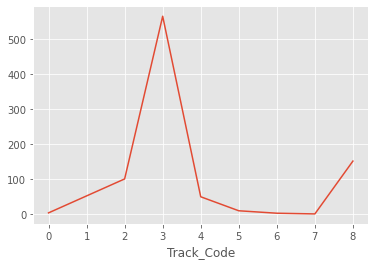

In [29]:
df_by_track = df.groupby("Track_Code")["Churn"].sum()
df_by_track.plot()

## ENCODE de la columna TRACK
##### 1) 'ARCHTC'=Architect
##### 2) 'CONSUL'=Consultant
##### 3) 'DEVELO'=Developer
##### 4) 'MNGSER'=ManagementServices
##### 5) 'PROJCT'=Project
##### 6) 'SERMGT'=ServiceManager
##### 7) 'SUPPOR'=Support
##### 8) 'SYINCO'=SystemIntegration

In [32]:
df.Track.unique()

array(['DEVELO', 'MNGSER', 'PROJCT', 'CONSUL', 'SYINCO', 'ARCHTC',
       'SERMGT', 'SUPPOR'], dtype=object)

In [33]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse='False')
enc_df = pd.DataFrame(enc.fit_transform(df[['Track']]).toarray(),
                     columns=['TRACK_Architect', 'TRACK_Consultant', 'TRACK_Developer', 'TRACK_ManagementServices', 'TRACK_Project', 'TRACK_ServiceManager',
        'TRACK_Support', 'TRACK_SystemIntegration'])
enc.categories_  

[array(['ARCHTC', 'CONSUL', 'DEVELO', 'MNGSER', 'PROJCT', 'SERMGT',
        'SUPPOR', 'SYINCO'], dtype=object)]

In [34]:
enc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TRACK_Architect           2627 non-null   float64
 1   TRACK_Consultant          2627 non-null   float64
 2   TRACK_Developer           2627 non-null   float64
 3   TRACK_ManagementServices  2627 non-null   float64
 4   TRACK_Project             2627 non-null   float64
 5   TRACK_ServiceManager      2627 non-null   float64
 6   TRACK_Support             2627 non-null   float64
 7   TRACK_SystemIntegration   2627 non-null   float64
dtypes: float64(8)
memory usage: 164.3 KB


In [35]:
df = df.join(enc_df.set_index(df.index))

In [36]:
# Descomentar las siguientes 2 líneas para eliminar las columnas reemplazadas por las transpuestas con ENCODE
columnas_drop=['Track','Track_Code']
df.drop(columnas_drop, axis=1, inplace=True)

In [37]:
df.head()

,ID_Country,Country,Employee_Pay_ST,Level_Cat,Level,Termination_Reason,Edad,Marital_CD,SBR_AMT,SCR_AMT,...,PS_Other,PS_SAP,TRACK_Architect,TRACK_Consultant,TRACK_Developer,TRACK_ManagementServices,TRACK_Project,TRACK_ServiceManager,TRACK_Support,TRACK_SystemIntegration
1,2,MX,Active,5,Sr. Consultant,Still Active,54,2,79.21,22.58,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2,MX,Active,3,Experienced Consultant,Still Active,49,2,42.00,12.00,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,2,MX,Active,4,Project / Technical Lead,Still Active,47,2,103.30,29.50,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,2,MX,Active,5,Sr. Consultant,Still Active,47,2,146.60,41.90,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
28,2,MX,Active,5,Sr. Consultant,Still Active,47,2,115.30,32.90,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [38]:
print(df.groupby("Country")["Churn"].count())

Country
AR     530
BR      62
CL     118
CO      47
CZ      30
ES     615
IN      11
MX    1179
PE      24
US      11
Name: Churn, dtype: int64


In [37]:
print(df.groupby("Country")["Churn"].sum())

Country
AR    226.0
BR     14.0
CL     46.0
CO     13.0
CZ     19.0
ES    223.0
IN      1.0
MX    334.0
PE      7.0
US      4.0
Name: Churn, dtype: float64


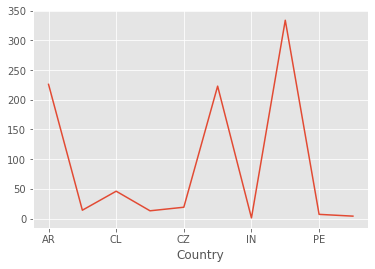

In [39]:
df_by_Country = df.groupby("Country")["Churn"].sum()
df_by_Country.plot()

In [39]:
print(df.groupby("Months_Worked")["Churn"].count())

Months_Worked
0     15
1     25
2     54
3     61
4     57
      ..
68    11
69     6
70     6
71     8
72     9
Name: Churn, Length: 73, dtype: int64


In [40]:
print(df.groupby("Months_Worked")["Churn"].sum())

Months_Worked
0     15.0
1     25.0
2     30.0
3     25.0
4     18.0
      ... 
68     2.0
69     1.0
70     3.0
71     1.0
72     3.0
Name: Churn, Length: 73, dtype: float64


In [41]:
df_by_month = df.groupby("Months_Worked")["Churn"].sum()

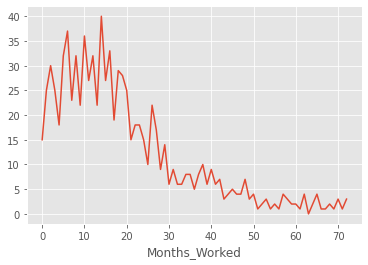

In [42]:
df_by_month.plot()

In [43]:
print(df.groupby("Edad")["Churn"].count())

Edad
18      1
19      1
20      4
21      9
22     30
23     60
24     80
25    125
26    148
27    185
28    180
29    157
30    187
31    129
32    144
33    147
34     95
35    110
36    110
37     94
38     78
39     67
40     62
41     47
42     42
43     41
44     45
45     36
46     26
47     37
48     22
49     24
50     24
51     16
52     10
53     11
54      9
55     10
56      8
57      4
58      6
59      1
60      2
61      2
64      1
Name: Churn, dtype: int64


In [44]:
print(df.groupby("Edad")["Churn"].sum())

Edad
18     1.0
19     0.0
20     0.0
21     1.0
22    11.0
23    20.0
24    30.0
25    40.0
26    65.0
27    69.0
28    73.0
29    68.0
30    61.0
31    34.0
32    59.0
33    38.0
34    33.0
35    29.0
36    38.0
37    32.0
38    26.0
39    24.0
40    16.0
41    16.0
42    14.0
43    15.0
44    11.0
45     7.0
46     4.0
47     8.0
48     7.0
49     8.0
50     8.0
51     5.0
52     2.0
53     4.0
54     2.0
55     2.0
56     2.0
57     0.0
58     2.0
59     0.0
60     0.0
61     2.0
64     0.0
Name: Churn, dtype: float64


In [45]:
df_by_age = df.groupby("Edad")["Churn"].sum()

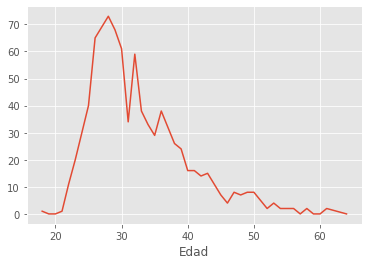

In [46]:
df_by_age.plot()

In [47]:
print(df.groupby("Department")["Churn"].count())

Department
303       22
D72       33
DH3       26
H48       39
Other    530
S04      180
S48       27
S51       89
S63      280
S64      783
S65       34
S66       57
S73       37
S76      230
T22       30
T25       59
T45       52
T57       56
T60       35
ZZ3       28
Name: Churn, dtype: int64


In [48]:
print(df.groupby("Department")["Churn"].sum())

Department
303        2.0
D72        6.0
DH3        0.0
H48        1.0
Other    300.0
S04        0.0
S48       27.0
S51        6.0
S63      280.0
S64       34.0
S65       34.0
S66       57.0
S73       37.0
S76       55.0
T22       30.0
T25        1.0
T45        6.0
T57        7.0
T60        4.0
ZZ3        0.0
Name: Churn, dtype: float64


In [49]:
print(df.groupby("Increase_2018_2019")["Churn"].count())

Increase_2018_2019
0.000000     2546
3.758906       80
47.500000       1
Name: Churn, dtype: int64


In [50]:
print(df.groupby("Increase_2018_2019")["Churn"].sum())

Increase_2018_2019
0.000000     887.0
3.758906       0.0
47.500000      0.0
Name: Churn, dtype: float64


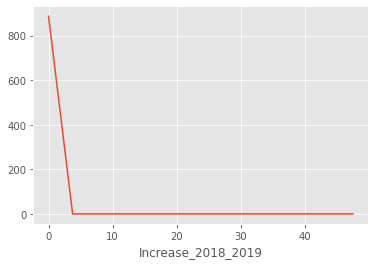

In [51]:
df_by_incr1 = df.groupby("Increase_2018_2019")["Churn"].sum()
df_by_incr1.plot()

In [52]:
print(df.groupby("Increase_2019_2020")["Churn"].sum())

Increase_2019_2020
0.000000      602.0
18.000000       0.0
18.656007       0.0
20.000000     262.0
21.000000       0.0
              ...  
89.000000       0.0
91.000000       0.0
92.000000       0.0
96.000000       0.0
100.000000      1.0
Name: Churn, Length: 62, dtype: float64


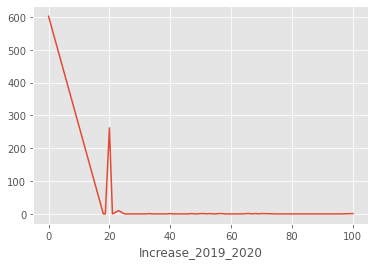

In [53]:
df_by_incr2 = df.groupby("Increase_2019_2020")["Churn"].sum()
df_by_incr2.plot()

In [40]:
df['Avg_Increase'] = df[['Increase_2018_2019', 'Increase_2019_2020']].mean(axis=1)
df.head()

,ID_Country,Country,Employee_Pay_ST,Level_Cat,Level,Termination_Reason,Edad,Marital_CD,SBR_AMT,SCR_AMT,...,PS_SAP,TRACK_Architect,TRACK_Consultant,TRACK_Developer,TRACK_ManagementServices,TRACK_Project,TRACK_ServiceManager,TRACK_Support,TRACK_SystemIntegration,Avg_Increase
1,2,MX,Active,5,Sr. Consultant,Still Active,54,2,79.21,22.58,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0
3,2,MX,Active,3,Experienced Consultant,Still Active,49,2,42.00,12.00,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0
6,2,MX,Active,4,Project / Technical Lead,Still Active,47,2,103.30,29.50,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10.0
9,2,MX,Active,5,Sr. Consultant,Still Active,47,2,146.60,41.90,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0
28,2,MX,Active,5,Sr. Consultant,Still Active,47,2,115.30,32.90,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.0


In [41]:
print(df.groupby('Avg_Increase')["Churn"].sum())

Avg_Increase
0.000000     602.0
9.000000       0.0
10.000000    262.0
10.500000      0.0
11.207457      0.0
             ...  
44.500000      0.0
45.500000      0.0
46.000000      0.0
48.000000      0.0
50.000000      1.0
Name: Churn, Length: 63, dtype: float64


In [42]:
df.drop(['Increase_2018_2019', 'Increase_2019_2020'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2627 entries, 1 to 3428
Data columns (total 68 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID_Country                      2627 non-null   int64  
 1   Country                         2627 non-null   object 
 2   Employee_Pay_ST                 2627 non-null   object 
 3   Level_Cat                       2627 non-null   int64  
 4   Level                           2627 non-null   object 
 5   Termination_Reason              2627 non-null   object 
 6   Edad                            2627 non-null   int64  
 7   Marital_CD                      2627 non-null   int64  
 8   SBR_AMT                         2627 non-null   float64
 9   SCR_AMT                         2627 non-null   float64
 10  Region                          2562 non-null   float64
 11  Office                          2627 non-null   int64  
 12  Area                            26

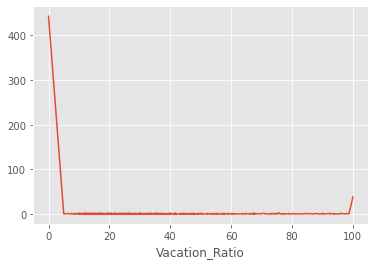

In [43]:
df_by_vacation = df.groupby("Vacation_Ratio")["Churn"].sum()
df_by_vacation.plot()

In [58]:
print(df.groupby("Marital_CD")["Churn"].count())

Marital_CD
1    1965
2     512
3     107
4      40
5       3
Name: Churn, dtype: int64


In [59]:
print(df.groupby("Level")["Churn"].count())

Level
Analyst                     631
Consultant                  599
Experienced Consultant      638
Project / Technical Lead     74
Sr. Consultant              685
Name: Churn, dtype: int64


In [60]:
print(df.groupby("Level")["Churn"].sum())

Level
Analyst                     245.0
Consultant                  206.0
Experienced Consultant      195.0
Project / Technical Lead     19.0
Sr. Consultant              222.0
Name: Churn, dtype: float64


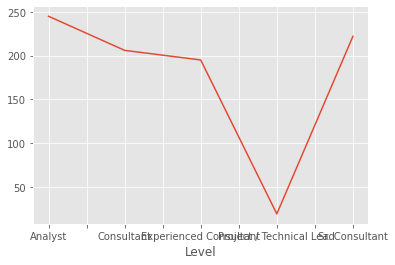

In [61]:
df_by_level = df.groupby("Level")["Churn"].sum()
df_by_level.plot()

## ENCODE de la columna LEVEL

##### 1=Analyst
##### 2=Consultant
##### 3=ExperiencedConsultant
##### 4=Project_TechnicalLead
##### 5=SrConsultant
##### 6=Managers

In [44]:
df.Level.unique()

array(['Sr. Consultant', 'Experienced Consultant',
       'Project / Technical Lead', 'Consultant', 'Analyst'], dtype=object)

In [45]:
# Convertimos a nombres validos para las columnas
df.loc[df['Level'] == 'Sr. Consultant', 'Level_STD'] = 'LEVEL_SrConsultant'
df.loc[df['Level'] == 'Experienced Consultant', 'Level_STD'] = 'LEVEL_ExperiencedConsultant'
df.loc[df['Level'] == 'Project / Technical Lead', 'Level_STD'] = 'LEVEL_Project_TechnicalLead'
df.loc[df['Level'] == 'Analyst', 'Level_STD'] = 'LEVEL_Analyst'
df.loc[df['Level'] == 'Consultant', 'Level_STD'] = 'LEVEL_Consultant'
df.loc[df['Level'] == 'Associate Director', 'Level_STD'] = 'LEVEL_Managers'
df.loc[df['Level'] == 'Manager / Master', 'Level_STD'] = 'LEVEL_Managers'
df.loc[df['Level'] == 'Sr. Manager / SME', 'Level_STD'] = 'LEVEL_Managers'

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2627 entries, 1 to 3428
Data columns (total 69 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID_Country                      2627 non-null   int64  
 1   Country                         2627 non-null   object 
 2   Employee_Pay_ST                 2627 non-null   object 
 3   Level_Cat                       2627 non-null   int64  
 4   Level                           2627 non-null   object 
 5   Termination_Reason              2627 non-null   object 
 6   Edad                            2627 non-null   int64  
 7   Marital_CD                      2627 non-null   int64  
 8   SBR_AMT                         2627 non-null   float64
 9   SCR_AMT                         2627 non-null   float64
 10  Region                          2562 non-null   float64
 11  Office                          2627 non-null   int64  
 12  Area                            26

In [47]:
DropColumns = ['Level','Level_Cat','Level_Cat.1']
df.drop(DropColumns, axis=1, inplace=True)

In [48]:
df.Level_STD.unique()

array(['LEVEL_SrConsultant', 'LEVEL_ExperiencedConsultant',
       'LEVEL_Project_TechnicalLead', 'LEVEL_Consultant', 'LEVEL_Analyst'],
      dtype=object)

In [49]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse='False')
enc_df = pd.DataFrame(enc.fit_transform(df[['Level_STD']]).toarray(),
                     columns=['LEVEL_Analyst', 'LEVEL_Consultant', 'LEVEL_ExperiencedConsultant',
        'LEVEL_Project_TechnicalLead', 'LEVEL_SrConsultant'])
enc.categories_  

[array(['LEVEL_Analyst', 'LEVEL_Consultant', 'LEVEL_ExperiencedConsultant',
        'LEVEL_Project_TechnicalLead', 'LEVEL_SrConsultant'], dtype=object)]

In [50]:
enc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   LEVEL_Analyst                2627 non-null   float64
 1   LEVEL_Consultant             2627 non-null   float64
 2   LEVEL_ExperiencedConsultant  2627 non-null   float64
 3   LEVEL_Project_TechnicalLead  2627 non-null   float64
 4   LEVEL_SrConsultant           2627 non-null   float64
dtypes: float64(5)
memory usage: 102.7 KB


In [51]:
df = df.join(enc_df.set_index(df.index))

In [52]:
# Descomentar las siguientes 2 líneas para eliminar las columnas reemplazadas por las transpuestas con ENCODE
columnas_drop=['Level_STD']
df.drop(columnas_drop, axis=1, inplace=True)

In [71]:
df.head()

,ID_Country,Country,Employee_Pay_ST,Termination_Reason,Edad,Marital_CD,SBR_AMT,SCR_AMT,Region,Office,...,TRACK_Project,TRACK_ServiceManager,TRACK_Support,TRACK_SystemIntegration,Avg_Increase,LEVEL_Analyst,LEVEL_Consultant,LEVEL_ExperiencedConsultant,LEVEL_Project_TechnicalLead,LEVEL_SrConsultant
1,2,MX,Active,Still Active,54,2,79.21,22.58,14.0,33,...,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,1.0
3,2,MX,Active,Still Active,49,2,42.00,12.00,14.0,33,...,0.0,0.0,0.0,0.0,10.0,0.0,0.0,1.0,0.0,0.0
6,2,MX,Active,Still Active,47,2,103.30,29.50,15.0,33,...,1.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0
9,2,MX,Active,Still Active,47,2,146.60,41.90,15.0,33,...,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,1.0
28,2,MX,Active,Still Active,47,2,115.30,32.90,15.0,33,...,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,1.0


In [72]:
print(df.groupby("Termination_Reason")["Churn"].count())

Termination_Reason
Still Active                     1740
Vol - Compensation & Benefits     148
Vol - Job Abandonment               1
Vol - Other                        38
Vol - Personal                    126
Vol - Project Discomfort           97
Vol - Supervisor / Leadership       9
Vol - Training & Career Dev       451
Vol - Transfer NEORIS Office        2
Vol - Transfer to CEMEX             9
Vol - Transfer to client            5
Vol - Work Environment              1
Name: Churn, dtype: int64


In [53]:
df['Termination_Code'] = df['Termination_Reason']
df['Termination_Code'] = df['Termination_Code'].replace(['Still Active','Vol - Compensation & Benefits','Vol - Personal','Vol - Project Discomfort','Vol - Training & Career Dev'],['V_StillActive','V_CompensationAndBenefits','V_Personal','V_ProjectDiscomfort','V_TrainingAndCareer'])
df['Termination_Code'] = df['Termination_Code'].replace(['Vol - Job Abandonment','Vol - Supervisor / Leadership','Vol - Other','Vol - Transfer NEORIS Office','Vol - Transfer to CEMEX','Vol - Transfer to client', 'Vol - Work Environment'],'V_OtherReasons')
df['Termination_Code'].unique()

array(['V_StillActive', 'V_TrainingAndCareer', 'V_OtherReasons',
       'V_ProjectDiscomfort', 'V_Personal', 'V_CompensationAndBenefits'],
      dtype=object)

In [54]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse='False')
enc_df = pd.DataFrame(enc.fit_transform(df[['Termination_Code']]).toarray(),
                     columns=['V_OtherReasons', 'V_CompensationAndBenefits', 'V_Personal',
        'V_ProjectDiscomfort', 'V_StillActive', 'V_TrainingAndCareer'])
enc.categories_  

[array(['V_CompensationAndBenefits', 'V_OtherReasons', 'V_Personal',
        'V_ProjectDiscomfort', 'V_StillActive', 'V_TrainingAndCareer'],
       dtype=object)]

In [55]:
enc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   V_OtherReasons             2627 non-null   float64
 1   V_CompensationAndBenefits  2627 non-null   float64
 2   V_Personal                 2627 non-null   float64
 3   V_ProjectDiscomfort        2627 non-null   float64
 4   V_StillActive              2627 non-null   float64
 5   V_TrainingAndCareer        2627 non-null   float64
dtypes: float64(6)
memory usage: 123.3 KB


In [56]:
df = df.join(enc_df.set_index(df.index))

In [57]:
# Descomentar las siguientes 2 líneas para eliminar las columnas reemplazadas por las transpuestas con ENCODE
columnas_drop=['Termination_Code']
df.drop(columnas_drop, axis=1, inplace=True)

In [58]:
df.head()

,ID_Country,Country,Employee_Pay_ST,Termination_Reason,Edad,Marital_CD,SBR_AMT,SCR_AMT,Region,Office,...,LEVEL_Consultant,LEVEL_ExperiencedConsultant,LEVEL_Project_TechnicalLead,LEVEL_SrConsultant,V_OtherReasons,V_CompensationAndBenefits,V_Personal,V_ProjectDiscomfort,V_StillActive,V_TrainingAndCareer
1,2,MX,Active,Still Active,54,2,79.21,22.58,14.0,33,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2,MX,Active,Still Active,49,2,42.00,12.00,14.0,33,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,2,MX,Active,Still Active,47,2,103.30,29.50,15.0,33,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,2,MX,Active,Still Active,47,2,146.60,41.90,15.0,33,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
28,2,MX,Active,Still Active,47,2,115.30,32.90,15.0,33,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [59]:
DropColumns = ['Country','Employee_Pay_ST','Department','Estado','Performance_Level','Potential_Level']
df.drop(DropColumns, axis=1, inplace=True)

In [60]:
df['Termination_Code'] = df['Termination_Reason']
df['Termination_Code'] = df['Termination_Code'].replace(['Still Active','Vol - Compensation & Benefits','Vol - Personal','Vol - Project Discomfort','Vol - Training & Career Dev'],[0,1,2,3,5])
df['Termination_Code'] = df['Termination_Code'].replace(['Vol - Job Abandonment','Vol - Supervisor / Leadership','Vol - Other','Vol - Transfer NEORIS Office','Vol - Transfer to CEMEX','Vol - Transfer to client', 'Vol - Work Environment'],6)
df.drop(['Termination_Reason'], axis=1, inplace=True)
df['Termination_Code'].unique()

array([0, 5, 6, 3, 2, 1], dtype=int64)

In [61]:
fill_nan_cols = ['Region', 'Bonus_2018', 'Bonus_2019']
df[fill_nan_cols] = df[fill_nan_cols].fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2627 entries, 1 to 3428
Data columns (total 70 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID_Country                      2627 non-null   int64  
 1   Edad                            2627 non-null   int64  
 2   Marital_CD                      2627 non-null   int64  
 3   SBR_AMT                         2627 non-null   float64
 4   SCR_AMT                         2627 non-null   float64
 5   Region                          2627 non-null   float64
 6   Office                          2627 non-null   int64  
 7   Area                            2627 non-null   int64  
 8   Division                        2627 non-null   int64  
 9   Department_CD                   2627 non-null   int64  
 10  Billiability                    2627 non-null   int64  
 11  Technology                      2627 non-null   int64  
 12  Business_Unit                   26

In [72]:
df[df['Cost_Centers']<0]=0
df[df['Cost_Centers']<0]

,ID_Country,Edad,Marital_CD,SBR_AMT,SCR_AMT,Region,Office,Area,Division,Department_CD,...,LEVEL_ExperiencedConsultant,LEVEL_Project_TechnicalLead,LEVEL_SrConsultant,V_OtherReasons,V_CompensationAndBenefits,V_Personal,V_ProjectDiscomfort,V_StillActive,V_TrainingAndCareer,Termination_Code


In [73]:
X,y = df.drop(['Churn'], axis = 1), df.Churn

In [74]:
y.sum()

887.0

In [75]:
model = DecisionTreeClassifier()

In [76]:
model.fit(X, y)

DecisionTreeClassifier()

In [77]:
importance = model.feature_importances_

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

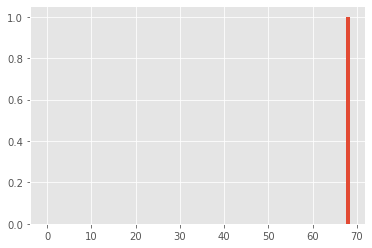

In [78]:
for i,v in enumerate(importance):
     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature: 0, Score: 0.00152
Feature: 1, Score: 0.00062
Feature: 2, Score: 0.00036
Feature: 3, Score: 0.00057
Feature: 4, Score: 0.00073
Feature: 5, Score: 0.00695
Feature: 6, Score: 0.00252
Feature: 7, Score: 0.00044
Feature: 8, Score: 0.00062
Feature: 9, Score: 0.00442
Feature: 10, Score: 0.00035
Feature: 11, Score: 0.00120
Feature: 12, Score: 0.00062
Feature: 13, Score: 0.00135
Feature: 14, Score: 0.00280
Feature: 15, Score: 0.00200
Feature: 16, Score: 0.00056
Feature: 17, Score: 0.00092
Feature: 18, Score: 0.00082
Feature: 19, Score: 0.00028
Feature: 20, Score: 0.00023
Feature: 21, Score: 0.00084
Feature: 22, Score: 0.00004
Feature: 23, Score: 0.00003
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00016
Feature: 26, Score: 0.00015
Feature: 27, Score: 0.00018
Feature: 28, Score: 0.00007
Feature: 29, Score: 0.00023
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00216
Feature: 33, Score: 0.00501
Feature: 34, Score: 0.00452
Feature: 35, Score: 0.00487
Fe

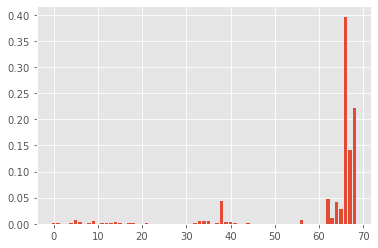

In [79]:
model = ExtraTreesClassifier()
model.fit(X,y)
importance = model.feature_importances_
for i,v in enumerate(importance):
     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


Feature: 0, Score: 0.00307
Feature: 1, Score: 0.00189
Feature: 2, Score: 0.00043
Feature: 3, Score: 0.00164
Feature: 4, Score: 0.00188
Feature: 5, Score: 0.01076
Feature: 6, Score: 0.00333
Feature: 7, Score: 0.00013
Feature: 8, Score: 0.00216
Feature: 9, Score: 0.03179
Feature: 10, Score: 0.00014
Feature: 11, Score: 0.00137
Feature: 12, Score: 0.00222
Feature: 13, Score: 0.00342
Feature: 14, Score: 0.00897
Feature: 15, Score: 0.00781
Feature: 16, Score: 0.00256
Feature: 17, Score: 0.00103
Feature: 18, Score: 0.00565
Feature: 19, Score: 0.00115
Feature: 20, Score: 0.00081
Feature: 21, Score: 0.00438
Feature: 22, Score: 0.00030
Feature: 23, Score: 0.00008
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00013
Feature: 26, Score: 0.00025
Feature: 27, Score: 0.00055
Feature: 28, Score: 0.00042
Feature: 29, Score: 0.00093
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00992
Feature: 33, Score: 0.01364
Feature: 34, Score: 0.01182
Feature: 35, Score: 0.00403
Fe

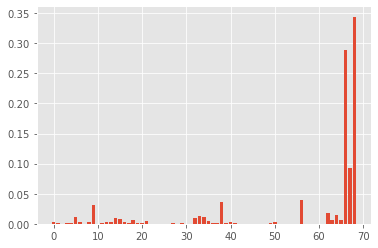

In [80]:
model = RandomForestClassifier()
model.fit(X,y)
importance = model.feature_importances_
for i,v in enumerate(importance):
     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


In [81]:
bestfeatures = SelectKBest(score_func=chi2, k=30)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 30 best features


                             Specs         Score
21               Billable_Projects  23942.851317
34              Logs_Global_Campus  20922.251915
8                         Division   6743.657354
68                Termination_Code   6544.126268
40      TotalNumberOfficeEmployees   4260.720240
56                    Avg_Increase   4094.184591
22       Corporate_Funded_Projects   4046.485232
33              Logs_Course_Viewed   2331.607054
14                   Months_Worked   1855.096877
35                Media_hora_curso   1691.500298
18               Abscence_Projects   1459.240973
15                  Vacation_Ratio   1260.874355
25    Internal_Investment_Projects   1027.951404
66                   V_StillActive    885.470690
67             V_TrainingAndCareer    884.712514
32                   Course_Viewed    800.765234
20               Awaiting_Projects    595.838676
19        Administrative_Functions    452.945679
62                  V_OtherReasons    290.326945
16          Number_U

In [82]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
bestfeatures = SelectKBest(score_func=chi2, k=30)
fit = bestfeatures.fit(X_scaled,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 30 best features


                             Specs        Score
68                Termination_Code  1090.687711
66                   V_StillActive   885.470690
67             V_TrainingAndCareer   884.712514
62                  V_OtherReasons   290.326945
64                      V_Personal   247.170237
65             V_ProjectDiscomfort   190.281849
63       V_CompensationAndBenefits   127.508455
56                    Avg_Increase    81.883692
39              Potential_Level_CD    75.592304
38            Performance_Level_CD    59.419219
33              Logs_Course_Viewed    43.177908
34              Logs_Global_Campus    42.097086
35                Media_hora_curso    35.239590
14                   Months_Worked    25.765234
32                   Course_Viewed    17.794783
51        TRACK_ManagementServices    13.403916
41                          PS_App    13.037123
15                  Vacation_Ratio    12.608744
36  Total_number_received_Feedback    10.744808
44    PS_OtherAdministrativeSkills    10

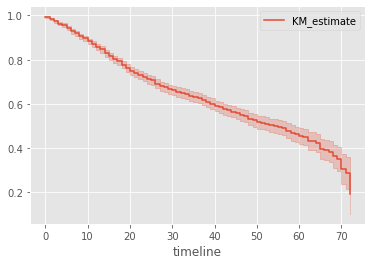

In [84]:
kmf = KaplanMeierFitter()
kmf.fit(durations = df['Months_Worked'], event_observed = df['Churn'])

kmf.event_table
kmf.predict([10,20,30,40, 50, 60, 72])
kmf.plot()


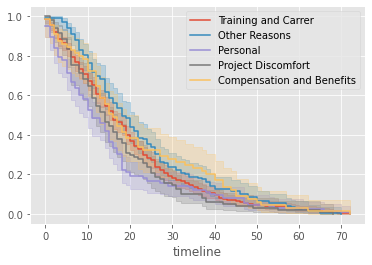

In [85]:
T = df['Months_Worked']
E = df['Churn']

group1 = df['V_TrainingAndCareer'] == 1
group2 = df['V_OtherReasons'] == 1
group3 = df['V_Personal'] == 1
group4 = df['V_ProjectDiscomfort'] == 1
group5 = df['V_CompensationAndBenefits'] == 1

kmf.fit(T[group1], E[group1], label='Training and Carrer')
ax = kmf.plot()

kmf.fit(T[group2], E[group2], label='Other Reasons')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax)

kmf.fit(T[group3], E[group3], label='Personal')        ## fit the cohort 3 data
ax2 = kmf.plot(ax=ax1) 

kmf.fit(T[group4], E[group4], label='Project Discomfort')        ## fit the cohort 3 data
ax3 = kmf.plot(ax=ax2)

kmf.fit(T[group5], E[group5], label='Compensation and Benefits')        ## fit the cohort 3 data
kmf.plot(ax=ax3)


In [95]:
def survival_features(df_in):
    ''' Function to execute the Survival Analysis for a dataframe and plot the results
    IN: dataframe with specific features
    '''
    for column in df_in:
   # Select column contents by column name using [] operator
        group = df[column] == 1
        kmf.fit(T[group], E[group], label=column)
        ax = kmf.plot()


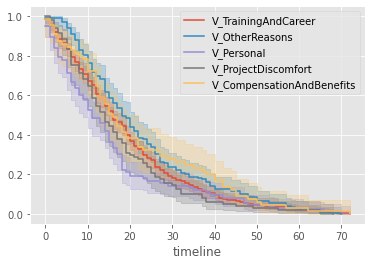

In [96]:
df_Term_Reason = df[['V_TrainingAndCareer', 'V_OtherReasons', 'V_Personal', 'V_ProjectDiscomfort', 'V_CompensationAndBenefits']]
survival_features(df_Term_Reason)

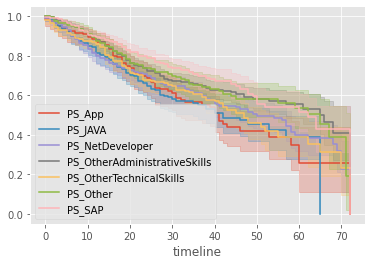

In [103]:
df_skill = df[['PS_App','PS_JAVA', 'PS_NetDeveloper', 'PS_OtherAdministrativeSkills', 'PS_OtherTechnicalSkills', 'PS_Other', 'PS_SAP']]
survival_features(df_skill)

ValueError: Values must be numeric: no strings, datetimes, objects, etc.

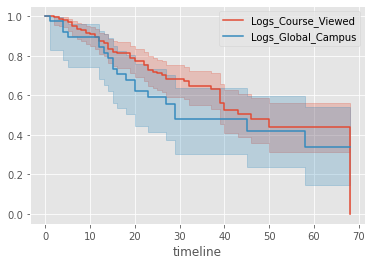

In [105]:
df_Education = df[['Logs_Course_Viewed','Logs_Global_Campus', 'Media_hora_curso', 'Course_Viewed']]
survival_features(df_Education)

In [147]:
df.describe()

,ID_Country,Edad,Marital_CD,SBR_AMT,SCR_AMT,Region,Office,Area,Division,Department_CD,...,LEVEL_Project_TechnicalLead,LEVEL_SrConsultant,V_OtherReasons,V_CompensationAndBenefits,V_Personal,V_ProjectDiscomfort,V_StillActive,V_TrainingAndCareer,Termination_Code,Churn
count,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,...,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000,2627.000000
mean,3.745337,33.168633,1.325086,76.123776,21.752585,11.438904,21.173201,7.062429,103.515797,10.264941,...,0.028169,0.260373,0.056338,0.024743,0.047963,0.036924,0.661211,0.171679,1.269890,0.337648
std,3.447166,7.580849,0.639038,42.040903,12.095191,5.625564,13.953631,1.032924,244.322741,4.128164,...,0.165487,0.438922,0.230617,0.155371,0.213730,0.188612,0.473388,0.377173,2.037692,0.472998
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,28.000000,1.000000,42.370000,12.000000,12.000000,8.000000,7.000000,35.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,32.000000,1.000000,69.630000,19.940000,14.000000,33.000000,7.000000,36.000000,11.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,6.000000,37.000000,2.000000,102.765000,29.320000,15.000000,33.000000,7.000000,37.000000,11.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000
max,17.000000,64.000000,5.000000,410.000000,116.000000,18.000000,48.000000,24.000000,994.000000,21.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000


In [148]:
#apply SelectKBest class to extract top 30 best features
bestfeatures = SelectKBest(score_func=chi2, k=30)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 30 best features

                             Specs         Score
21               Billable_Projects  23942.851317
34              Logs_Global_Campus  20922.251915
8                         Division   6743.657354
68                Termination_Code   6544.126268
40      TotalNumberOfficeEmployees   4260.720240
56                    Avg_Increase   4094.184591
22       Corporate_Funded_Projects   4046.485232
33              Logs_Course_Viewed   2331.607054
14                   Months_Worked   1855.096877
35                Media_hora_curso   1691.500298
18               Abscence_Projects   1459.240973
15                  Vacation_Ratio   1260.874355
25    Internal_Investment_Projects   1027.951404
66                   V_StillActive    885.470690
67             V_TrainingAndCareer    884.712514
32                   Course_Viewed    800.765234
20               Awaiting_Projects    595.838676
19        Administrative_Functions    452.945679
62                  V_OtherReasons    290.326945
16          Number_U